# Call Option Parameters

In [2]:
# Parameters
S0 = 100
K = 80
T = 1
r = 0.05
sigma = 0.2

# PDE Discretization

European Call Option Price via Explicit PDE: 24.5854


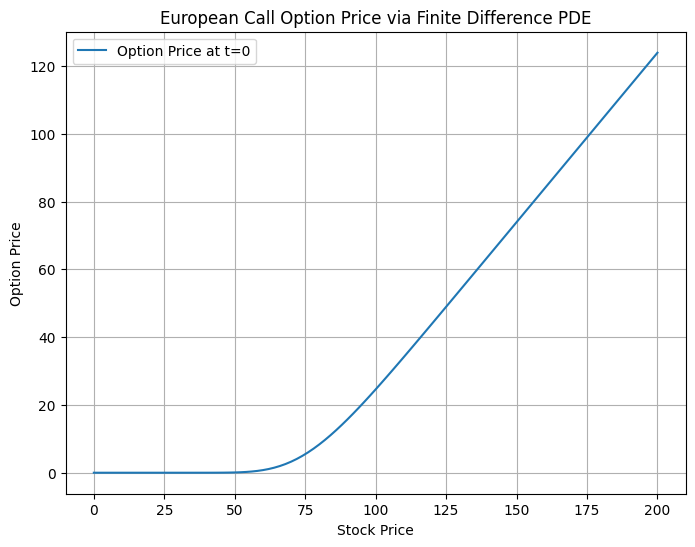

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Parameter Setup
# ---------------------------
S_max = 200.0      # maximum stock price to consider on the grid
N = 100            # number of stock price steps (spatial grid points)
M = 1000            # number of time steps

# Define step sizes
dS = S_max / N     # stock price increment
dt = T / M         # time increment

# ---------------------------
# 2. Grid Initialization
# ---------------------------
# grid[i, j] approximates the option price at S = i*dS and time t = j*dt.
grid = np.zeros((N+1, M+1))

# Stock price values corresponding to grid indices
S_vals = np.linspace(0, S_max, N+1)

# Terminal condition: at expiry (t = T), the option payoff is max(S-K, 0)
grid[:, -1] = np.maximum(S_vals - K, 0)

# Lower boundary: if S=0, a call option is worthless.
grid[0, :] = 0

# Upper boundary condition: for high S, the call option price approaches S - K*exp(-r*(T-t)).
# We use this to set the price at S_max for all times.
for j in range(M+1):
    t = j * dt
    grid[-1, j] = S_max - K * np.exp(-r * (T - t))

# ---------------------------
# 3. Finite Difference Backward Induction
# ---------------------------
# We use an explicit scheme to step backward from expiry (t = T) to t = 0.
# The Black-Scholes PDE is:
#   V_t + 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V = 0.
#
# Discretizations:
#   V_t ≈ (V[i, j] - V[i, j+1]) / dt      (backward difference in time)
#   V_S ≈ (V[i+1, j+1] - V[i-1, j+1]) / (2*dS)   (central difference)
#   V_SS ≈ (V[i+1, j+1] - 2*V[i, j+1] + V[i-1, j+1]) / (dS)^2   (central difference)
#
# Rearranging, we update V[i, j] as:
#   V[i, j] = V[i, j+1] + dt * (0.5 * sigma**2 * (S_i)**2 * V_SS +
#                               r* S_i * V_S - r* V[i, j+1])
for j in reversed(range(M)):
    for i in range(1, N):  # skip i=0 and i=N because of boundary conditions
        # Current stock price at grid node i
        S_i = i * dS
        
        # First derivative (Delta) using central difference at time j+1:
        delta = (grid[i+1, j+1] - grid[i-1, j+1]) / (2 * dS)
        
        # Second derivative (Gamma) using central difference at time j+1:
        gamma = (grid[i+1, j+1] - 2 * grid[i, j+1] + grid[i-1, j+1]) / (dS ** 2)
        
        # Explicit finite difference time-stepping:
        grid[i, j] = grid[i, j+1] + dt * (
            0.5 * sigma ** 2 * S_i ** 2 * gamma + 
            r * S_i * delta - 
            r * grid[i, j+1]
        )

# ---------------------------
# 4. Extracting and Plotting the Result
# ---------------------------
# To obtain the option price for a stock price of 100, we interpolate the grid at S=100.
price_at_100 = np.interp(100, S_vals, grid[:, 0])
print(f"European Call Option Price via Explicit PDE: {price_at_100:.4f}")

# Optional: plot the option price at time t=0 as function of stock price
plt.figure(figsize=(8, 6))
plt.plot(S_vals, grid[:, 0], label="Option Price at t=0")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("European Call Option Price via Finite Difference PDE")
plt.legend()
plt.grid(True)
plt.show()


# MonteCarlo Simulation

In [4]:
import numpy as np

# Parameters
num_paths = 10000
num_steps = 100
dt = T / num_steps

# Simulating stock price paths
np.random.seed(42)
S_paths = np.zeros((num_paths, num_steps+1))
S_paths[:, 0] = 100  # Initial price

for t in range(1, num_steps+1):
    dW = np.sqrt(dt) * np.random.randn(num_paths)
    S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)

# Compute call option price
option_payoffs = np.maximum(S_paths[:, -1] - K, 0)
call_price = np.exp(-r * T) * np.mean(option_payoffs)
print(f"Monte Carlo Call Option Price: {call_price:.4f}")


Monte Carlo Call Option Price: 24.2472


# Analytic solution

In [5]:
import numpy as np
from scipy.stats import norm

# Black-Scholes Formula
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

call_price_bs = black_scholes_call(S0, K, T, r, sigma)
print(f"Black-Scholes Call Price: {call_price_bs:.4f}")


Black-Scholes Call Price: 24.5888


# Chf Approach (Numerical methods when density isn't known explicitly)

In [6]:
import numpy as np

# Parameters
N     = 4 * 32    # Number of COS expansion terms (here, 128)
L     = 10        # Truncation domain scaling parameter
i     = 1j        # Imaginary unit
tau   = T         # For clarity, tau = T

#----------------------#
# COS Helper Functions #
#----------------------#

def Chi_Psi(a, b, c, d, k):
    """
    Computes the Chi and Psi coefficients for the COS method.
    
    The coefficients are used to approximate the payoff function in the Fourier cosine expansion.
    
    Parameters:
      a, b : float
          The truncation domain endpoints.
      c, d : float
          The integration limits for the payoff function.
      k    : array_like
          COS expansion indices (can be 0,...,N-1).
    
    Returns:
      dict with "chi" and "psi" coefficients.
    """
    # Compute Psi_k
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a))
    # Adjust values for k >= 1; for k==0 just use d-c.
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    # Compute Chi_k
    chi = 1.0 / (1.0 + (k * np.pi / (b - a))**2)
    expr1 = np.cos(k * np.pi * (d - a) / (b - a)) * np.exp(d) - np.cos(k * np.pi * (c - a) / (b - a)) * np.exp(c)
    expr2 = (k * np.pi / (b - a)) * (np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a)) * np.exp(c))
    chi = chi * (expr1 + expr2)
    
    return {"chi": chi, "psi": psi}

def CallPutCoefficients(a, b, k):
    """
    Computes the COS method payoff coefficients for a call option.
    
    For call options, the integration limits in the COS method are typically chosen with:
       c = 0
       d = b
    and the coefficients are defined as:
       H_k = 2/(b-a) * (Chi_k - Psi_k).
    """
    c = 0.0
    d = b
    coef = Chi_Psi(a, b, c, d, k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    H_k = 2.0 / (b - a) * (Chi_k - Psi_k)
    return H_k

def CallPutOptionPriceCOSMthd(cf, S0, r, tau, K, N, L):
    """
    Prices a call option using the COS method.
    
    Parameters:
       cf  : function
           Characteristic function (without the exp(i*u*x0) term, which is handled separately).
       S0  : float
           Current asset price.
       r   : float
           Risk-free rate.
       tau : float
           Time to maturity.
       K   : float (or scalar)
           Strike price.
       N   : integer
           Number of COS expansion terms.
       L   : float
           Truncation domain scaling parameter.
    
    Returns:
       A float: the COS method call option price.
    """
    # For a single strike, x0 is a scalar.
    x0 = np.log(S0 / K)
    
    # Define the truncation domain [a, b]:
    a = -L * np.sqrt(tau)
    b =  L * np.sqrt(tau)
    
    # Create index vector k and corresponding frequencies u:
    k = np.linspace(0, N - 1, N)  # 1D array of indices
    u = k * np.pi / (b - a)        # COS frequencies
    
    # Compute the COS payoff coefficients for a call option.
    H_k = CallPutCoefficients(a, b, k)  # 1D array, length N.
    
    # Build the COS expansion vector.
    # For a single strike, use elementwise multiplication:
    mat = np.exp(i * (x0 - a) * u)  # 1D array of length N
    
    # Compute the product of the characteristic function and the coefficients.
    temp = cf(u) * H_k  # 1D array (length N)
    temp[0] = 0.5 * temp[0]  # Adjustment for the first term in the COS series.
    
    # COS method option price
    value = np.exp(-r * tau) * K * np.real(np.dot(mat, temp))
    return value

#-------------------------------#
# Characteristic Function (BS)  #
#-------------------------------#

# Note: In the COS method, we do not include the factor exp(i*u*x0) in the cf.
cf = lambda u: np.exp((r - 0.5 * sigma**2) * i * u * T - 0.5 * sigma**2 * T * (u**2))

#---------------------#
# Main Calculation    #
#---------------------#

val_COS = CallPutOptionPriceCOSMthd(cf, S0, r, T, K, N, L)
print(f"COS Method Call Price is {val_COS:.4f}")


COS Method Call Price is 24.6229
